#            Machine Learning project : Visualization & Outbreak prediction of Covid19 
                    

In [61]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score,recall_score, f1_score, confusion_matrix
import datetime
import operator 
import seaborn as sns 
from scipy.signal import find_peaks
plt.style.use('fivethirtyeight')



In [62]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-19-2020.csv')
covid = pd.read_csv('datasets_566027_1266186_corona_morocco.csv')

In [63]:
latest_data.head()


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001.0,Abbeville,South Carolina,US,2020-06-20 04:33:19,34.223334,-82.461707,73,0,0,73,"Abbeville, South Carolina, US",297.631182,0.000000
1,22001.0,Acadia,Louisiana,US,2020-06-20 04:33:19,30.295065,-92.414197,639,32,0,607,"Acadia, Louisiana, US",1029.897655,5.007825
2,51001.0,Accomack,Virginia,US,2020-06-20 04:33:19,37.767072,-75.632346,1022,14,0,1008,"Accomack, Virginia, US",3162.520114,1.369863
3,16001.0,Ada,Idaho,US,2020-06-20 04:33:19,43.452658,-116.241552,1100,22,0,1078,"Ada, Idaho, US",228.411481,2.000000
4,19001.0,Adair,Iowa,US,2020-06-20 04:33:19,41.330756,-94.471059,12,0,0,12,"Adair, Iowa, US",167.785235,0.000000


In [64]:
confirmed_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,854,854,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,148,155,166,172,176,183,186,189,197,212


In [65]:
cols = confirmed_df.keys()

In [66]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]


In [67]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
morocco_cases = [] 
morocco_deaths = [] 
morocco_recoveries = [] 



for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)
    
    # case study 
    morocco_cases.append(confirmed_df[confirmed_df['Country/Region']=='Morocco'][i].sum())
    morocco_deaths.append(deaths_df[deaths_df['Country/Region']=='Morocco'][i].sum())
    morocco_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='Morocco'][i].sum())
    


In [68]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)
morocco_daily_increase = daily_increase(morocco_cases)


# deaths
world_daily_death = daily_increase(total_deaths)
morocco_daily_death = daily_increase(morocco_deaths)

# recoveries
world_daily_recovery = daily_increase(total_recovered)
morocco_daily_recovery = daily_increase(morocco_recoveries)




In [69]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [70]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [71]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

# Covid-19 Worldwide visualization & outbreak prediction

# Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate (CFR), and recovery rate


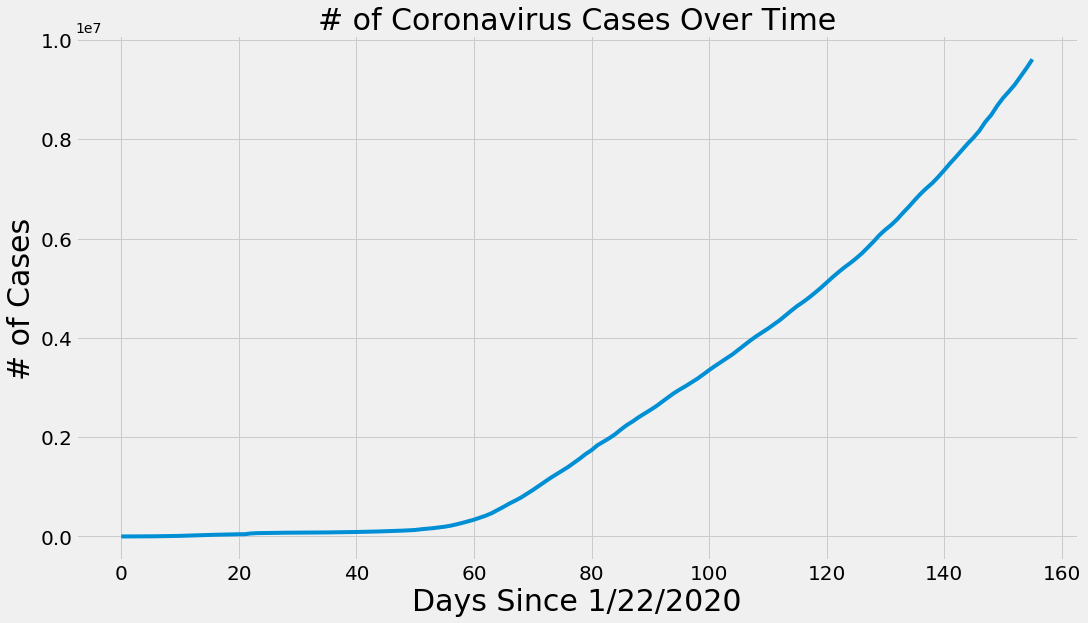

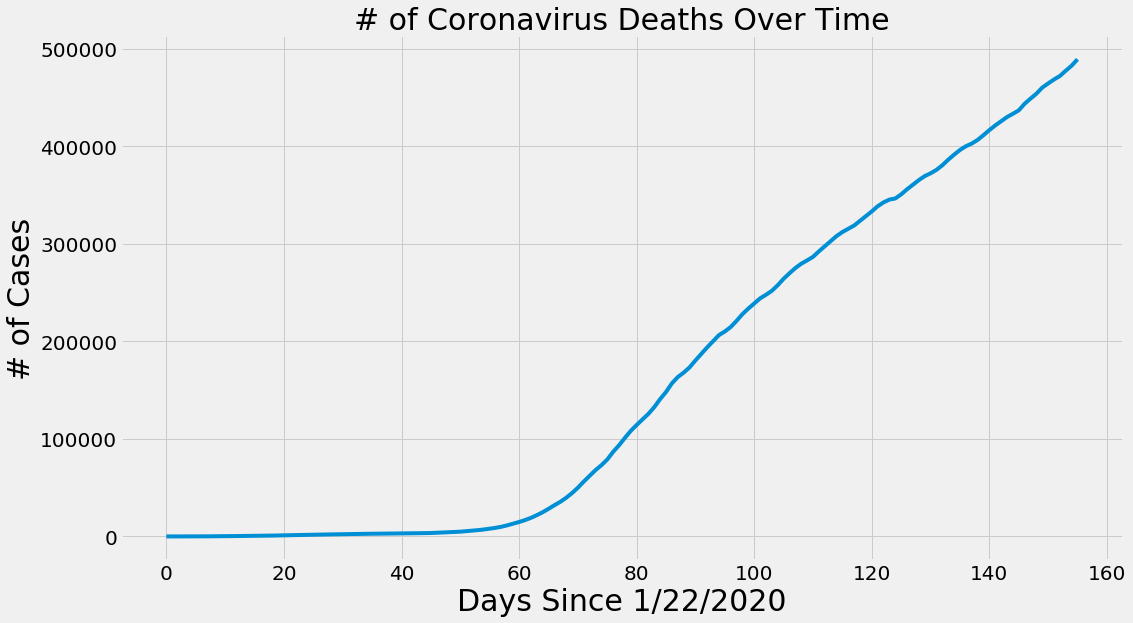

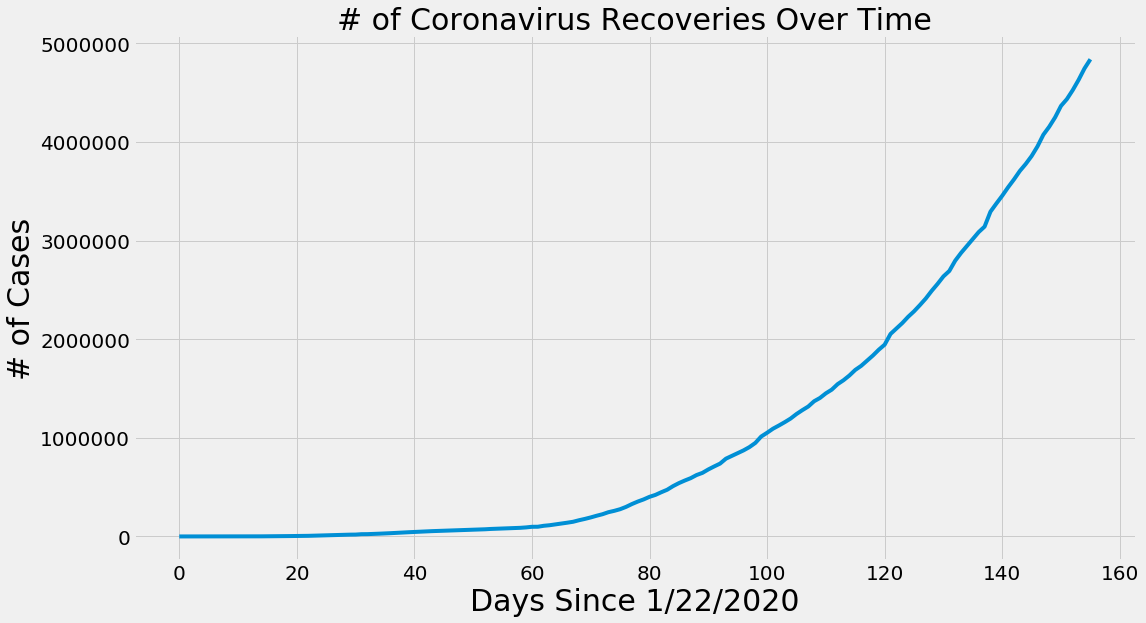

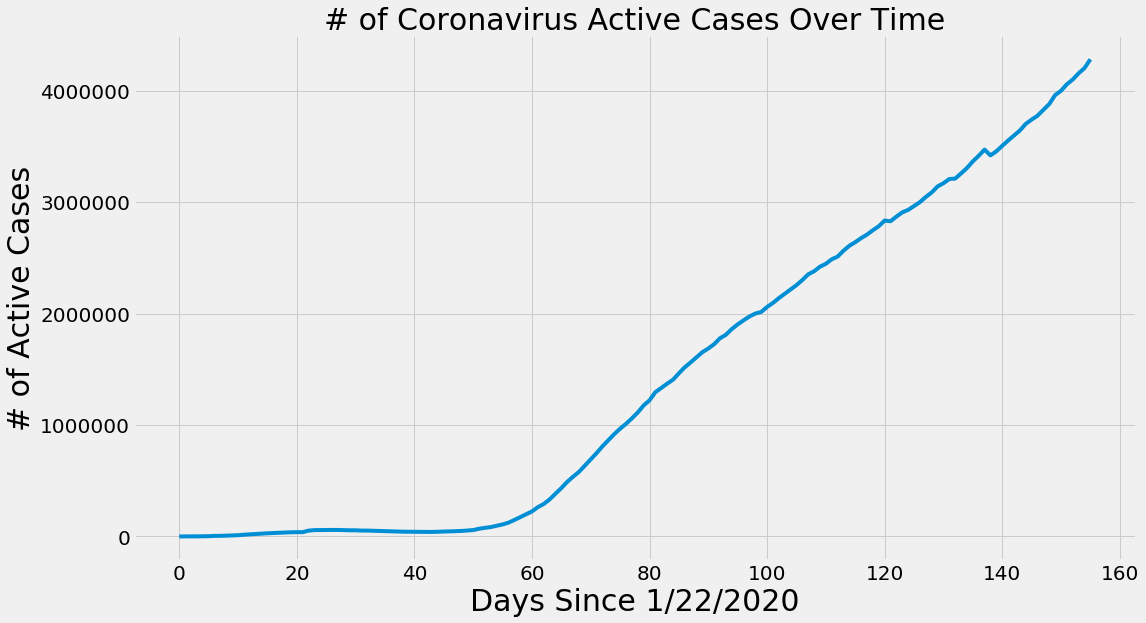

In [72]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths)
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered)
plt.title('# of Coronavirus Recoveries Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active)
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

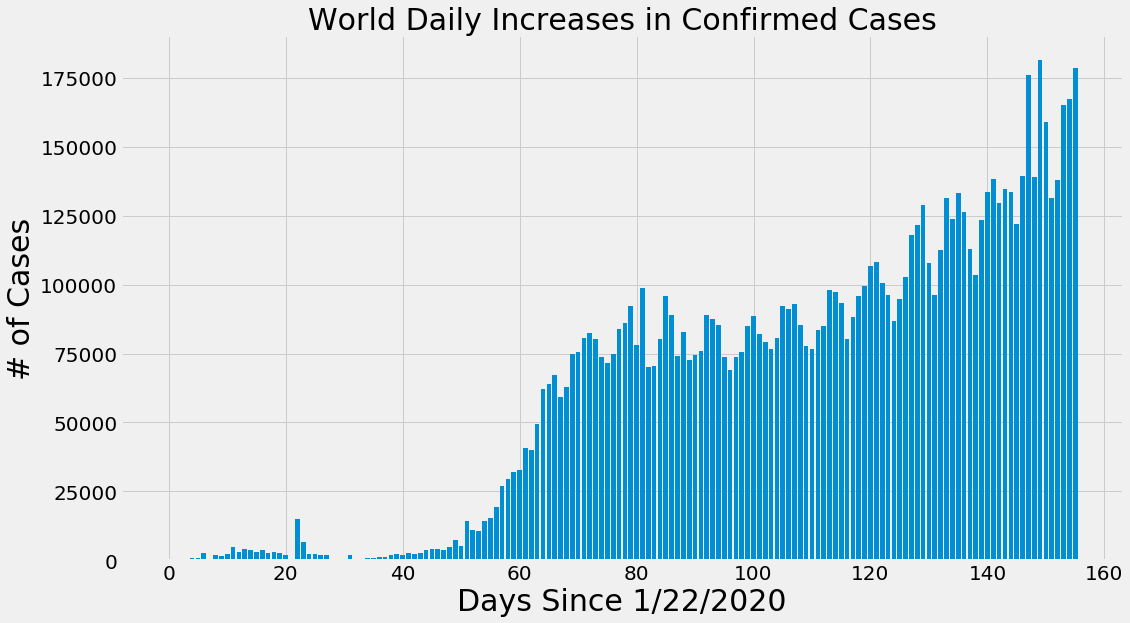

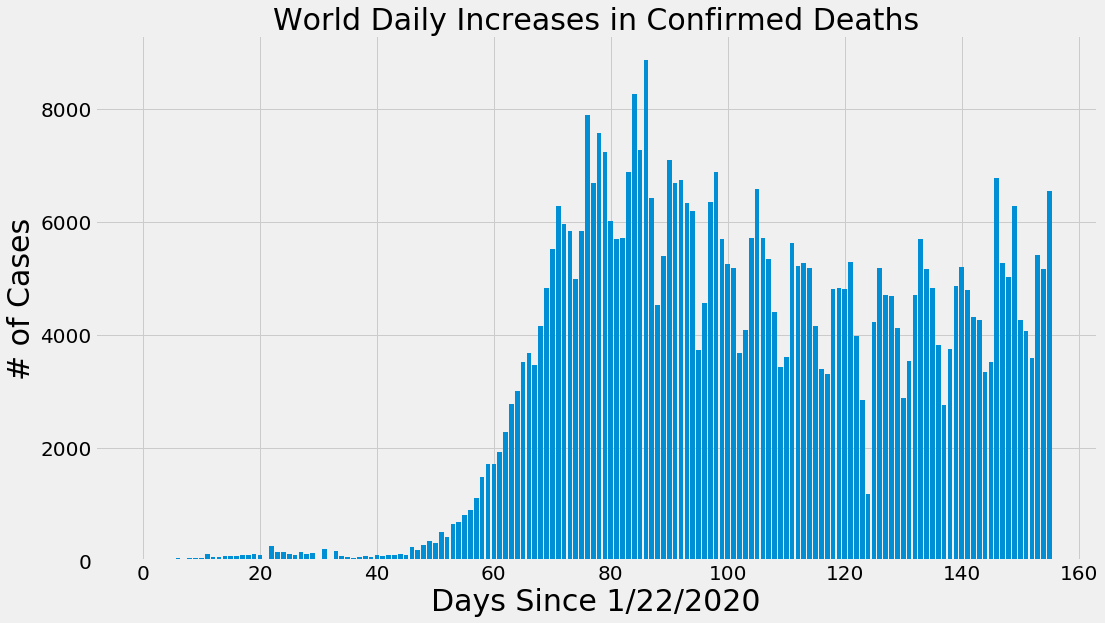

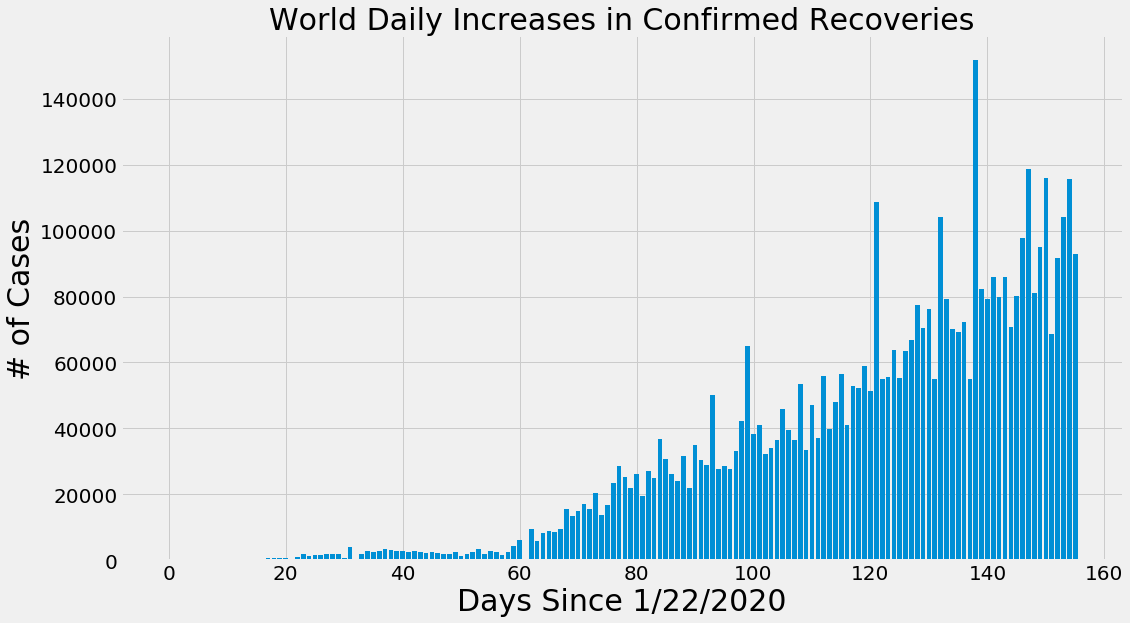

In [73]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_death)
plt.title('World Daily Increases in Confirmed Deaths', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_recovery)
plt.title('World Daily Increases in Confirmed Recoveries', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

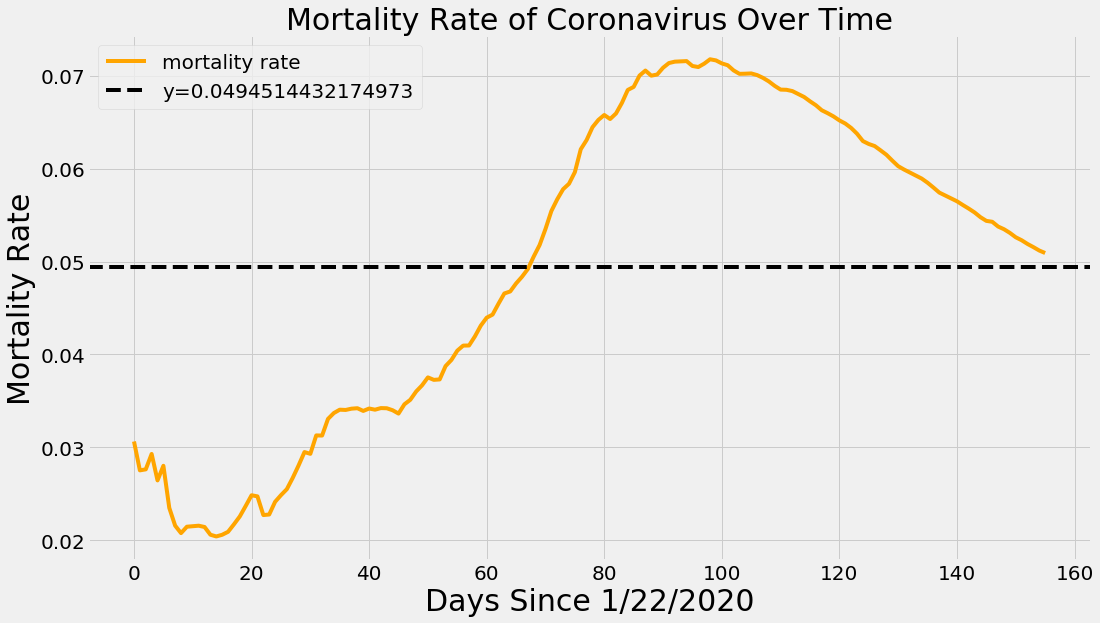

In [74]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

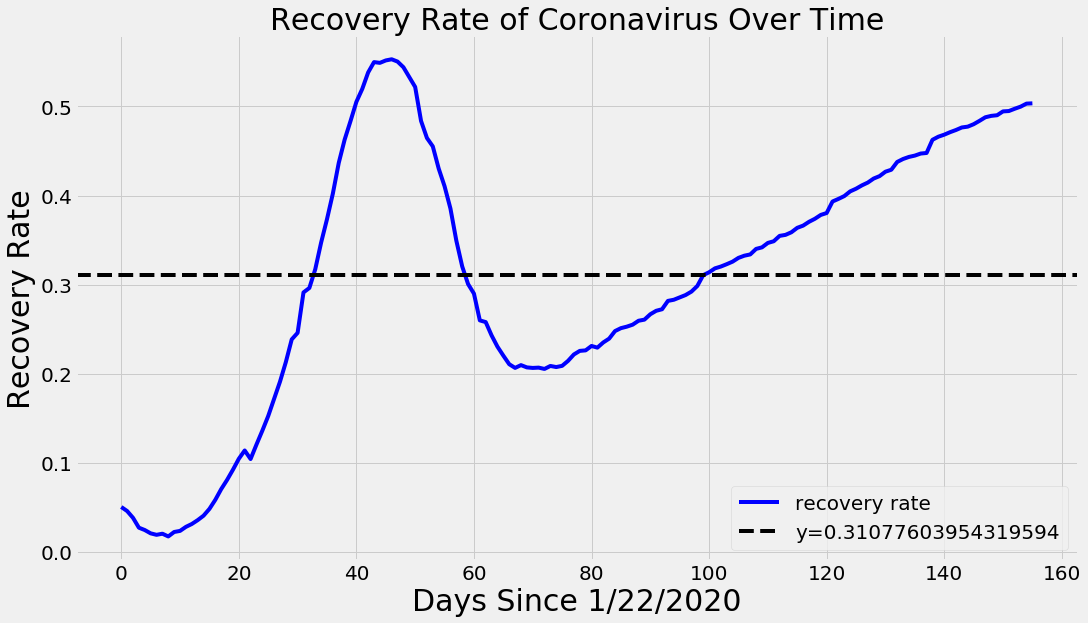

In [75]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

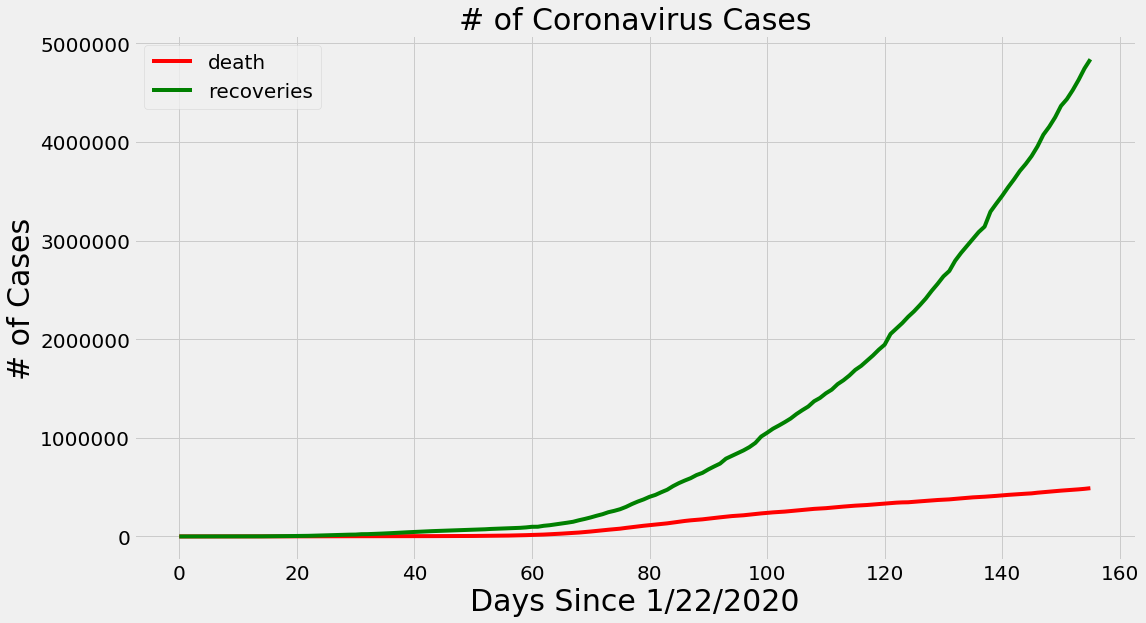

In [76]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 1/22/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

# Predictions for confirmed coronavirus cases worldwide

In [77]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22[50:], world_cases[50:], test_size=0.14, shuffle=False) 

In [78]:
# # use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [79]:
# svm_search.best_params_
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=3, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

/home/zetta/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 264414.1490013685
MSE: 74110067405.84415


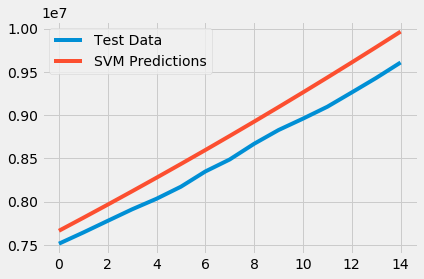

In [80]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [81]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)


In [82]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 95360.1778857708
MSE: 17685338871.281483


In [83]:
print(linear_model.coef_)

[[ 3.09968005e+07 -1.73282587e+06  3.61915707e+04 -3.53819287e+02
   1.68706626e+00 -3.11616645e-03]]


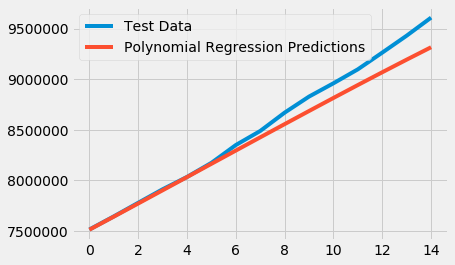

In [84]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [85]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forcast, pred, linestyle='dashed', color=color)
    plt.title('# of Coronavirus Cases Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('# of Cases', size=30)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

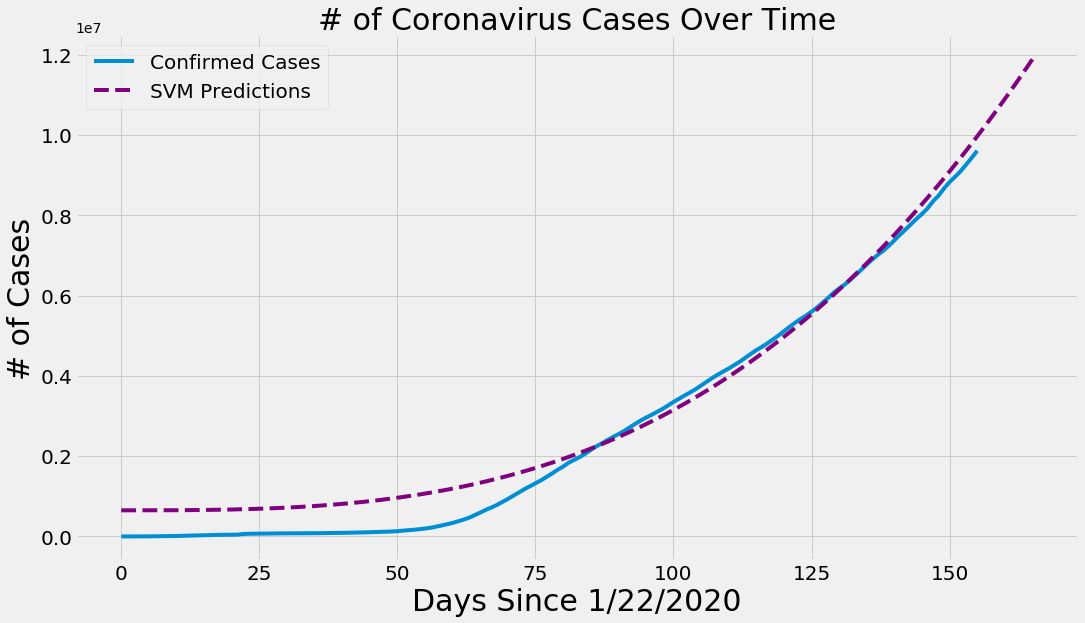

In [86]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVM Predictions', 'purple')

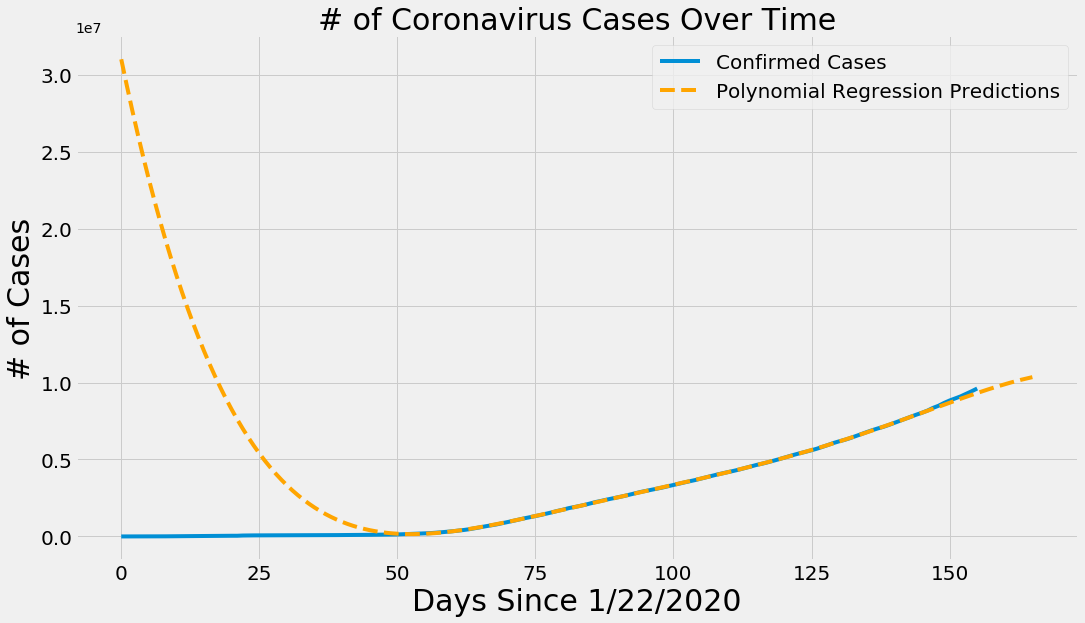

In [87]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Polynomial Regression Predictions', 'orange')

In [88]:
# Future predictions using SVM 
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Worldwide': np.round(svm_pred[-10:])})
svm_df

,Date,SVM Predicted # of Confirmed Cases Worldwide
0,06/26/2020,10148575.0
1,06/27/2020,10332387.0
2,06/28/2020,10518556.0
3,06/29/2020,10707096.0
4,06/30/2020,10898022.0
5,07/01/2020,11091351.0
6,07/02/2020,11287095.0
7,07/03/2020,11485272.0
8,07/04/2020,11685895.0
9,07/05/2020,11888979.0


In [89]:
# Future predictions using polynomial regression
linear_pred = linear_pred.reshape(1,-1)[0]
svm_df = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Worldwide': np.round(linear_pred[-10:])})
svm_df

,Date,Polynomial Predicted # of Confirmed Cases Worldwide
0,06/26/2020,9437152.0
1,06/27/2020,9554653.0
2,06/28/2020,9669067.0
3,06/29/2020,9780011.0
4,06/30/2020,9887081.0
5,07/01/2020,9989857.0
6,07/02/2020,10087897.0
7,07/03/2020,10180742.0
8,07/04/2020,10267910.0
9,07/05/2020,10348900.0


# Morocco Specific Graphs


In [90]:
# slightly modify the data to fit the model better (regression models cannot pick the pattern)
X_train_confirmed1, X_test_confirmed1, y_train_confirmed1, y_test_confirmed1 = train_test_split(days_since_1_22[50:], morocco_cases[50:], test_size=0.14, shuffle=False) 


In [91]:
svm_confirmed.fit(X_train_confirmed1, y_train_confirmed1)
svm_pred1 = svm_confirmed.predict(future_forcast)

In [92]:
# check against testing data
svm_test_pred1 = svm_confirmed.predict(X_test_confirmed1)
print('MAE1:', mean_absolute_error(svm_test_pred1, y_test_confirmed1))
print('MSE1:',mean_squared_error(svm_test_pred1, y_test_confirmed1))

MAE1: 3754.464105761617
MSE1: 14300346.108514624


In [93]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed1 = poly.fit_transform(X_train_confirmed1)
poly_X_test_confirmed1 = poly.fit_transform(X_test_confirmed1)
poly_future_forcast1 = poly.fit_transform(future_forcast)

In [94]:
# polynomial regression
linear_model1 = LinearRegression(normalize=True, fit_intercept=False)
linear_model1.fit(poly_X_train_confirmed1, y_train_confirmed1)
test_linear_pred1 = linear_model1.predict(poly_X_test_confirmed1)
linear_pred1 = linear_model1.predict(poly_future_forcast1)
print('MAE1:', mean_absolute_error(test_linear_pred1, y_test_confirmed1))
print('MSE1:',mean_squared_error(test_linear_pred1, y_test_confirmed1))

MAE1: 264.2326113353173
MSE1: 96164.61509953623


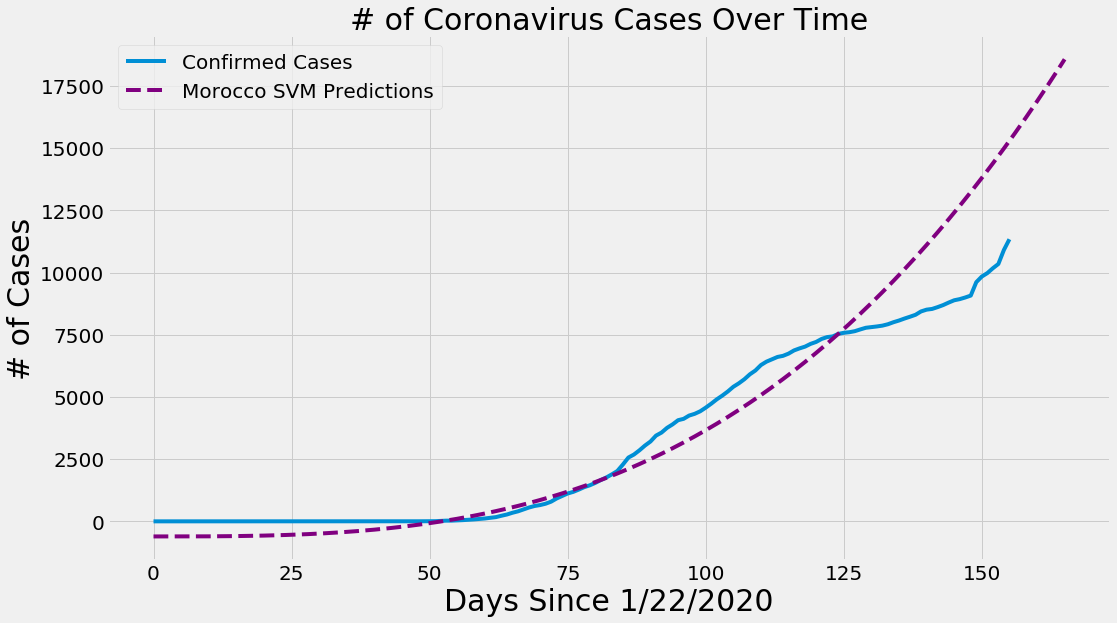

In [95]:
plot_predictions(adjusted_dates, morocco_cases, svm_pred1, 'Morocco SVM Predictions', 'purple')

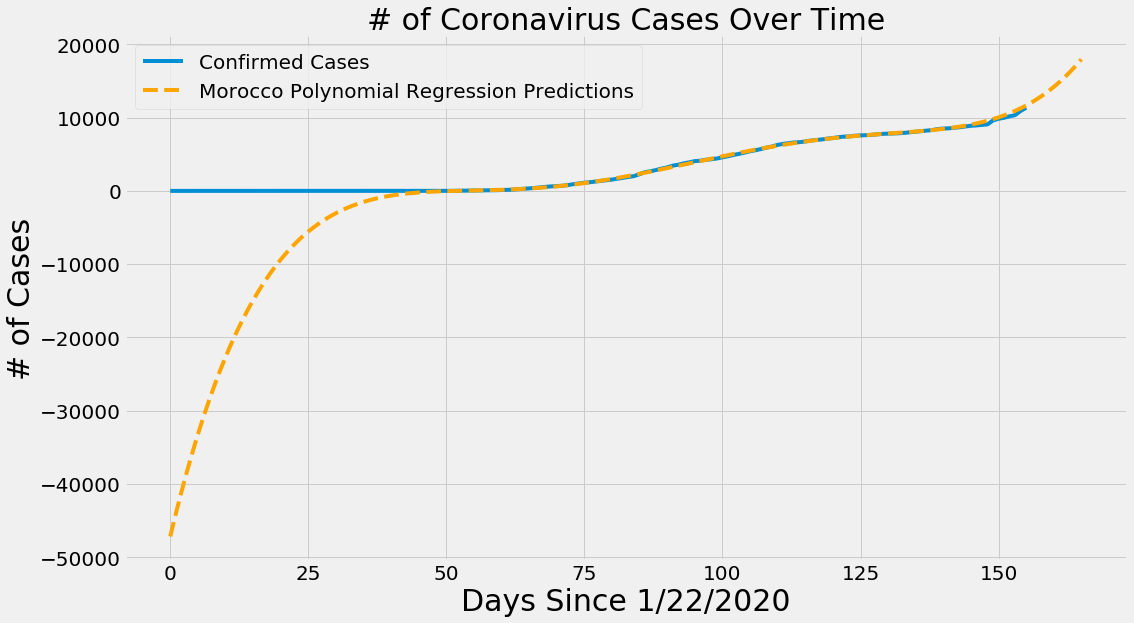

In [96]:
plot_predictions(adjusted_dates, morocco_cases, linear_pred1, 'Morocco Polynomial Regression Predictions', 'orange')

In [97]:
# Future predictions using SVM 
svm_df1 = pd.DataFrame({'Date': future_forcast_dates[-10:], 'SVM Predicted # of Confirmed Cases Morocco': np.round(svm_pred1[-10:])})
svm_df1

,Date,SVM Predicted # of Confirmed Cases Morocco
0,06/26/2020,15601.0
1,06/27/2020,15914.0
2,06/28/2020,16232.0
3,06/29/2020,16554.0
4,06/30/2020,16880.0
5,07/01/2020,17210.0
6,07/02/2020,17544.0
7,07/03/2020,17882.0
8,07/04/2020,18224.0
9,07/05/2020,18571.0


In [98]:
# Future predictions using polynomial regression
linear_pred1 = linear_pred1.reshape(1,-1)[0]
svm_df1 = pd.DataFrame({'Date': future_forcast_dates[-10:], 'Polynomial Predicted # of Confirmed Cases Morocco': np.round(linear_pred1[-10:])})
svm_df1

,Date,Polynomial Predicted # of Confirmed Cases Morocco
0,06/26/2020,12080.0
1,06/27/2020,12542.0
2,06/28/2020,13045.0
3,06/29/2020,13592.0
4,06/30/2020,14186.0
5,07/01/2020,14829.0
6,07/02/2020,15525.0
7,07/03/2020,16276.0
8,07/04/2020,17086.0
9,07/05/2020,17957.0


In [99]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.dates as dates

In [43]:
date1 = '1/22/20'
date2 = '6/24/20'
mydates = pd.date_range(date1, date2).tolist()

<h1> COVID-19 Morocco case study</h1>

In [ ]:
import numpy as np
#x = np.arange(2,3,4,5,6,7,7,8,5,6,8,9,10,9,11,12,10,12,13,12,14,13,12,14,15,16,15,17,16,18,19,20,21,22,23,24,25,26,27)
x=[1,2,3,4,5,6,7,7,8,5,6,8,9,10,9,11,12,10,12,13,12,14,13,12,14,15,16,15,17,16,18,19,20,21,22,23,24,25,26,27]
#morocco_daily_excluded0
z=[534325.0,557827.0,577000.0,598327.0]
#z= np.arange(534325.0,557827.0,577000.0,598327.0)
morocco_daily_excluded=np.concatenate([x,morocco_daily_excluded0,z])

In [138]:
morocco_daily_excluded0=covid['Excluded']
morocco_daily_excluded0


0          28.0
1          32.0
2          34.0
3          40.0
4          50.0
         ...   
106    446837.0
107    462739.0
108    479873.0
109    496023.0
110    512327.0
Name: Excluded, Length: 111, dtype: float64

.

In [150]:
length=len(morocco_daily_excluded)
total_test_daily=[]
total_test_daily=morocco_daily_excluded+morocco_daily_increase
total_test_daily

array([1.00000e+00, 2.00000e+00, 3.00000e+00, 4.00000e+00, 5.00000e+00,
       6.00000e+00, 7.00000e+00, 7.00000e+00, 8.00000e+00, 5.00000e+00,
       6.00000e+00, 8.00000e+00, 9.00000e+00, 1.00000e+01, 9.00000e+00,
       1.10000e+01, 1.20000e+01, 1.00000e+01, 1.20000e+01, 1.30000e+01,
       1.20000e+01, 1.40000e+01, 1.30000e+01, 1.20000e+01, 1.40000e+01,
       1.50000e+01, 1.60000e+01, 1.50000e+01, 1.70000e+01, 1.60000e+01,
       1.80000e+01, 1.90000e+01, 2.00000e+01, 2.10000e+01, 2.20000e+01,
       2.30000e+01, 2.40000e+01, 2.50000e+01, 2.60000e+01, 2.70000e+01,
       2.90000e+01, 3.20000e+01, 3.40000e+01, 4.10000e+01, 5.00000e+01,
       5.50000e+01,         nan, 6.00000e+01, 6.40000e+01, 8.00000e+01,
               nan, 9.50000e+01,         nan, 1.33000e+02,         nan,
               nan, 2.74000e+02, 3.21000e+02, 3.88000e+02, 4.04000e+02,
       5.17000e+02, 6.71000e+02, 7.12000e+02, 7.95000e+02, 9.81000e+02,
       1.49300e+03, 1.63100e+03, 1.87100e+03, 2.27200e+03, 2.523

.

New dataframe

In [354]:
covid_morocco = {'date':  mydates,
        'morocco_daily_increase': morocco_daily_increase,
                 'morocco_daily_death':morocco_daily_death,
                 'morocco_daily_recovery':  morocco_daily_recovery,
                'morocco_daily_excluded':morocco_daily_excluded,
                 'total_test_daily':total_test_daily
                 
        }

df1 = pd.DataFrame (covid_morocco, columns = ['date','morocco_daily_increase','morocco_daily_death','morocco_daily_recovery','morocco_daily_excluded','total_test_daily'])

In [355]:
df1

,date,morocco_daily_increase,morocco_daily_death,morocco_daily_recovery,morocco_daily_excluded,total_test_daily
0,2020-01-22,0,0,0,1.0,1.0
1,2020-01-23,0,0,0,2.0,2.0
2,2020-01-24,0,0,0,3.0,3.0
3,2020-01-25,0,0,0,4.0,4.0
4,2020-01-26,0,0,0,5.0,5.0
...,...,...,...,...,...,...
150,2020-06-20,226,0,106,512327.0,512553.0
151,2020-06-21,138,1,61,534325.0,534463.0
152,2020-06-22,195,0,82,557827.0,558022.0
153,2020-06-23,172,0,41,577000.0,577172.0


In [205]:
covid=covid.fillna(0)
df1=df1.fillna(0)

<h2>Morocco daily increase</h2>

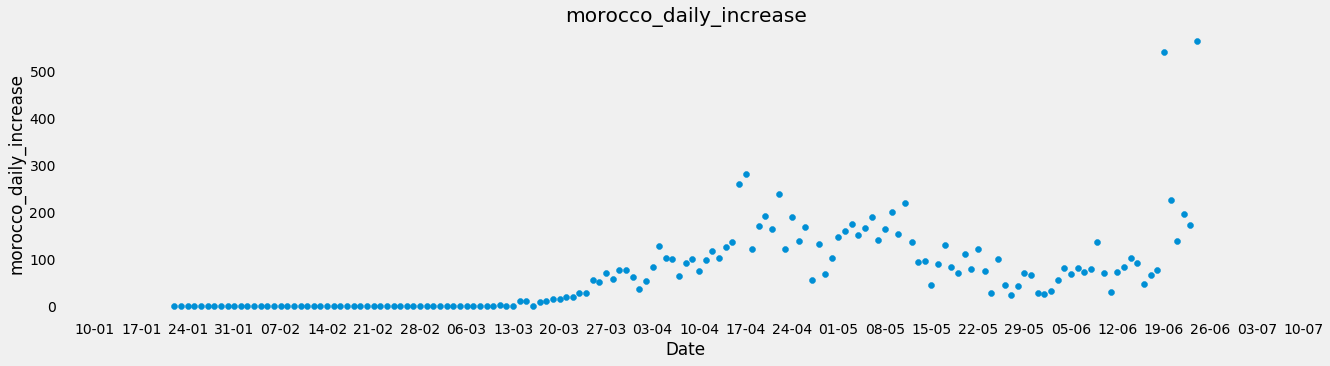

In [68]:
variable = "morocco_daily_increase"
fig, ax = plt.subplots(figsize=(20, 5))
ax.grid()
ax.scatter(mydates,morocco_daily_increase)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

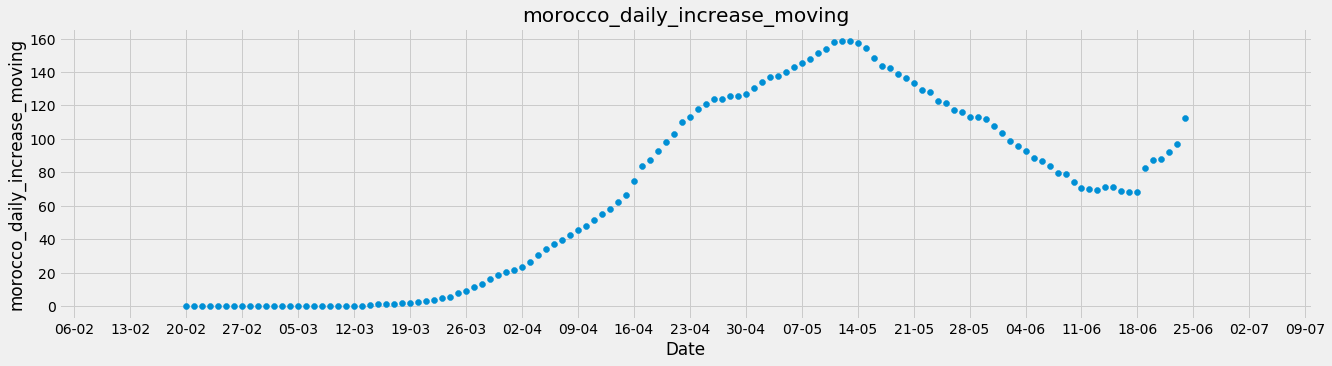

In [82]:
variable = "morocco_daily_increase_moving"
rolling_average_days = 30
morocco_daily_increase_moving=df1.morocco_daily_increase.rolling(window=rolling_average_days).mean()
#morocco_daily_increase_moving=data.rolling(window=rolling_average_days).mean()
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(mydates,morocco_daily_increase_moving)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

<h2>Morocco daily death</h2>

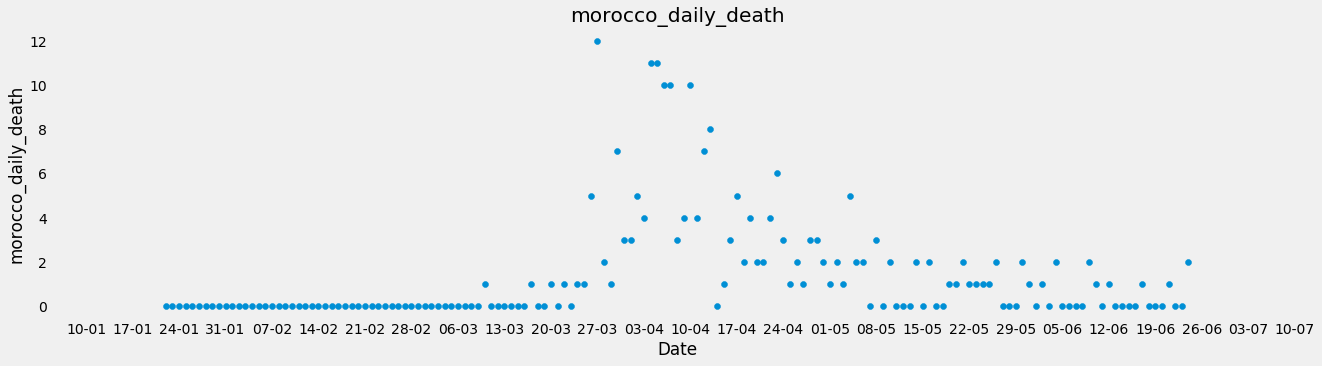

In [87]:
variable = "morocco_daily_death"
fig, ax = plt.subplots(figsize=(20, 5))
ax.grid()
ax.scatter(mydates,morocco_daily_death)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

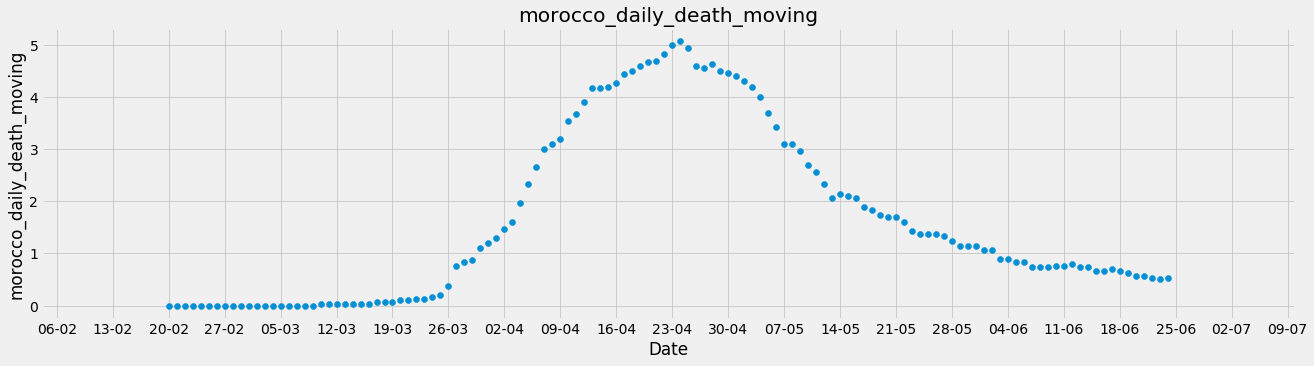

In [89]:
variable = "morocco_daily_death_moving"
rolling_average_days = 30
morocco_daily_death_moving=df1.morocco_daily_death.rolling(window=rolling_average_days).mean()
#morocco_daily_increase_moving=data.rolling(window=rolling_average_days).mean()
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(mydates,morocco_daily_death_moving)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

In [345]:
df1.date[92]

Timestamp('2020-04-23 00:00:00')

<h2>Morocco daily recovery</h2>

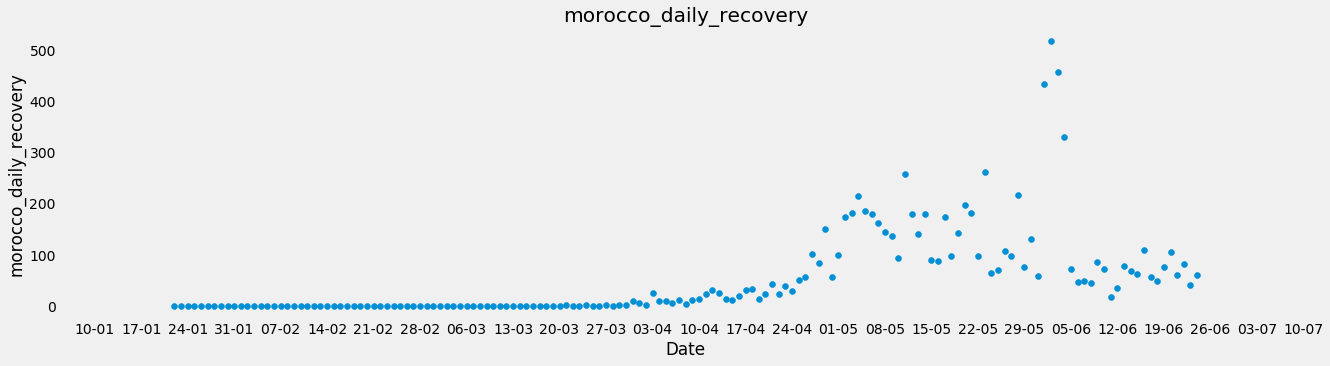

In [88]:
variable = "morocco_daily_recovery"
fig, ax = plt.subplots(figsize=(20, 5))
ax.grid()
ax.scatter(mydates,morocco_daily_recovery)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

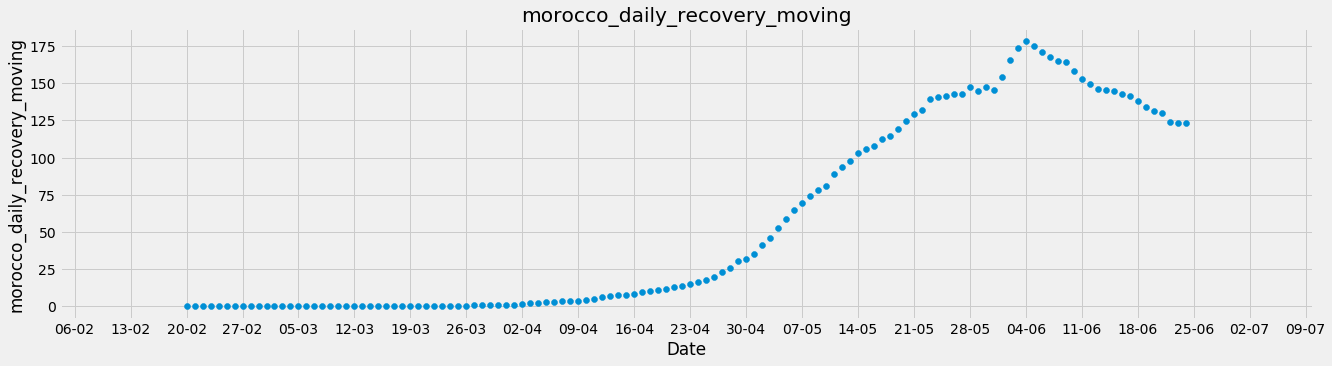

In [90]:
variable = "morocco_daily_recovery_moving"
rolling_average_days = 30
morocco_daily_recovery_moving=df1.morocco_daily_recovery.rolling(window=rolling_average_days).mean()
#morocco_daily_increase_moving=data.rolling(window=rolling_average_days).mean()
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(mydates,morocco_daily_recovery_moving)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter('%d-%m')
#date_form = covid.style.format({"Date": lambda t: t.strftime("%d-%m")}) 
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
fig.savefig(variable + '.png')
plt.show()

<h2>Morocco and  covid trapping</h2>

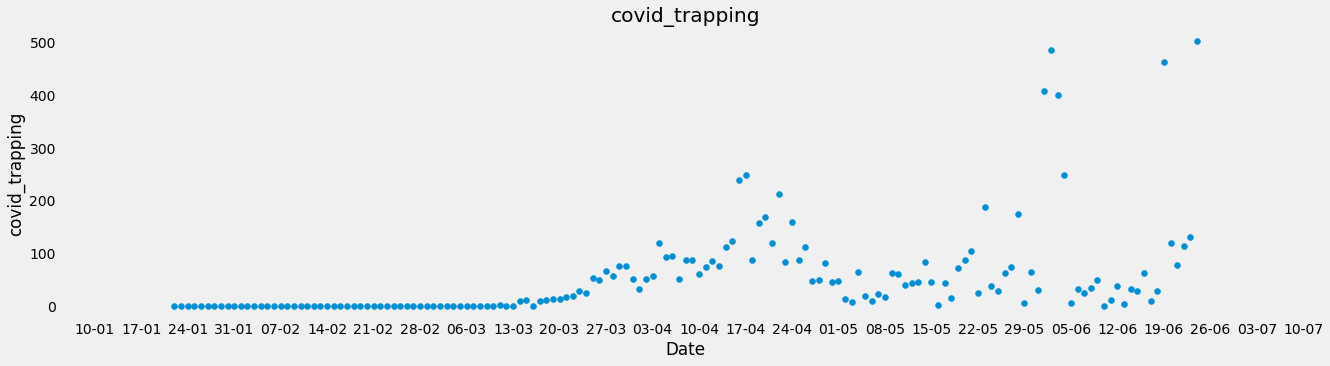

In [353]:
covid_trapping=abs(df1['morocco_daily_increase']-df1.morocco_daily_recovery)
variable = "covid_trapping"
fig, ax = plt.subplots(figsize=(20, 5))
ax.grid()
ax.scatter(mydates,covid_trapping)
ax.set(xlabel="Date",ylabel=variable,title=variable)
date_form = dates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(dates.DayLocator(interval = 7))
#ax.axvline(datetime(2020, 6, 2), c="green", zorder=0)
fig.savefig(variable + '.png')
plt.show()

In [280]:
import numpy as np
from sklearn import linear_model
# prepare the lists for the model
X = date_format
y = covid_trapping.tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
starting_date = 151
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# # let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print ("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

Linear Regression Model Score: 0.7846266324675236


<h3>Predicting the future trend</h3>

In [ ]:
# Predict future trend
from sklearn.metrics import max_error
import math
y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

In [309]:
X_test = []
future_days = 55
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

In [310]:
y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

<h3>Drawing forecasts</h3>

In [326]:
# convert date of the epidemic peak into datetime format
from datetime import datetime, timedelta
date_zero = df1.date[starting_date] 
#datetime.strptime(df1.date[starting_date], '%Y-%m-%dT%H:%M:%S')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 5
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

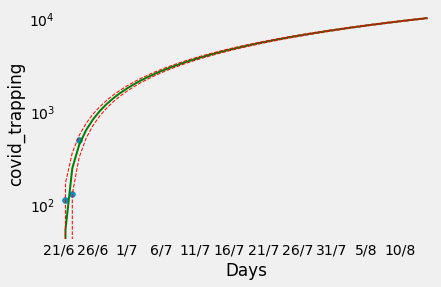

In [328]:
# plot known data
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
#plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('covid_trapping')
plt.yscale("log")
plt.savefig("prediction.png")
plt.show()

<h3>Death in Morocco </h3>

In [346]:
import numpy as np
from sklearn import linear_model
# prepare the lists for the model
X = date_format
y = morocco_daily_death_moving.tolist()[1:]
# date format is not suitable for modeling, let's transform the date into incrementals number starting from April 1st
starting_date = 92
day_numbers = []
for i in range(1, len(X)):
    day_numbers.append([i])
X = day_numbers
# # let's train our model only with data after the peak
X = X[starting_date:]
y = y[starting_date:]
# Instantiate Linear Regression
linear_regr = linear_model.LinearRegression()
# Train the model using the training sets
linear_regr.fit(X, y)
print ("Linear Regression Model Score: %s" % (linear_regr.score(X, y)))

Linear Regression Model Score: 0.872192623200973


<h3>Predicting the future trend</h3>

In [347]:
# Predict future trend
from sklearn.metrics import max_error
import math
y_pred = linear_regr.predict(X)
error = max_error(y, y_pred)

In [348]:
X_test = []
future_days = 60
for i in range(starting_date, starting_date + future_days):
    X_test.append([i])
y_pred_linear = linear_regr.predict(X_test)

In [349]:
y_pred_max = []
y_pred_min = []
for i in range(0, len(y_pred_linear)):
    y_pred_max.append(y_pred_linear[i] + error)
    y_pred_min.append(y_pred_linear[i] - error)

<h3>Drawing forecasts</h3>

In [350]:
# convert date of the epidemic peak into datetime format
from datetime import datetime, timedelta
date_zero = df1.date[starting_date] 
#datetime.strptime(df1.date[starting_date], '%Y-%m-%dT%H:%M:%S')
# creating x_ticks for making the plot more appealing
date_prev = []
x_ticks = []
step = 5
data_curr = date_zero
x_current = starting_date
n = int(future_days / step)
for i in range(0, n):
    date_prev.append(str(data_curr.day) + "/" + str(data_curr.month))
    x_ticks.append(x_current)
    data_curr = data_curr + timedelta(days=step)
    x_current = x_current + step

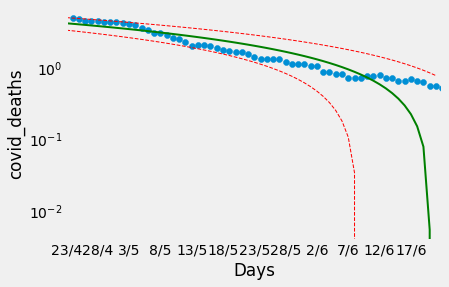

In [351]:
# plot known data
plt.grid()
plt.scatter(X, y)
# plot linear regression prediction
plt.plot(X_test, y_pred_linear, color='green', linewidth=2)
# plot maximum error
plt.plot(X_test, y_pred_max, color='red', linewidth=1, linestyle='dashed')
#plot minimum error
plt.plot(X_test, y_pred_min, color='red', linewidth=1, linestyle='dashed')
plt.xlabel('Days')
plt.xlim(starting_date, starting_date + future_days)
plt.xticks(x_ticks, date_prev)
plt.ylabel('covid_deaths')
plt.yscale("log")
plt.savefig("prediction.png")
plt.show()

.